### Recurrent Neural network

*In this exercise, we use Recurrent neural network (RNN) to predict German HICP inflation for similar dataset ('HICP_Ger.csv'), once again employing a univariate time series forecasting technique.*

*RNNs are a type of neural network used mainly for sequencial data such as time series forecasting and natural language processing.
RNNS suffer from the so-called vanishing gradient problem which arises during the process of model training when the gradient shrinks and becomes smaller during backwards propagations. This results in difficulties for the model to learn from very distant sequencial information* 


#### Long Short Term Memory
*LSTM overcome the vanishing gradient problem by employing some kind of comlex internal structure referred to as cells. These cells uses specialized gates (forget gates, input gates and output gates) to regulate the flow of information to and fro the cells, and this helps to control the long-terms information flow thereby mitigating/managing the vanishing gradient problem*

*We begin by importing the appropriate libraries below.*

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler 

import optuna
import torch.optim as optim # Optunais a powerful hyperparameter optimization framework.
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy as dc

import warnings
warnings.filterwarnings("ignore")

*Next, we import and clean the data, similar to scripts used for the ARIMA models. Please check the scripts for ARIMA for more details*

In [4]:
df = pd.read_csv('HICP_Ger.csv', sep='\\s+|,', engine="python")
df.head()

,"""DATE","""""TIME","PERIOD""""","""""HICP",""""""""
0,"""1996-01-31","""""1996Jan""""","""""0.5""""""",NaN,NaN
1,"""1996-02-29","""""1996Feb""""","""""0.7""""""",NaN,NaN
2,"""1996-03-31","""""1996Mar""""","""""0.8""""""",NaN,NaN
3,"""1996-04-30","""""1996Apr""""","""""0.5""""""",NaN,NaN
4,"""1996-05-31","""""1996May""""","""""0.7""""""",NaN,NaN


In [5]:
columns_to_drop = [1, 3, 4]
df.drop(df.columns[columns_to_drop], axis=1, inplace=True)
df.columns = df.columns.str.replace('"', '')
df.rename(columns = {"PERIOD":"HICP"}, inplace = True)
        

In [6]:
for cols in df:
    df[cols] = df[cols].str.strip('"')

df.head()

,DATE,HICP
0,1996-01-31,0.5
1,1996-02-29,0.7
2,1996-03-31,0.8
3,1996-04-30,0.5
4,1996-05-31,0.7


In [7]:
df['HICP'] = pd.to_numeric(df['HICP'])

In [8]:
df.set_index("DATE", inplace = True)
df.index = pd.to_datetime(df.index)
df.index.freq = "M"
df.index

DatetimeIndex(['1996-01-31', '1996-02-29', '1996-03-31', '1996-04-30',
               '1996-05-31', '1996-06-30', '1996-07-31', '1996-08-31',
               '1996-09-30', '1996-10-31',
               ...
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31'],
              dtype='datetime64[ns]', name='DATE', length=341, freq='M')

*PLotting of the HICP inflation series*

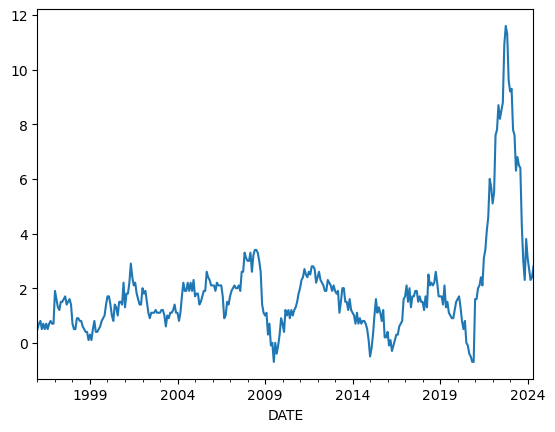

In [9]:
df['HICP'].plot();

#### Preparing the data
*In in order ensure that the data is suitable for supervised learning, we present the data in a form such that up to 12 lags of the series is used to predict current values of inflation. That implies transforming the dataset by creating lagged versions of the original series via sliding windows. Remember in a supervised learning setting, the idea is to train a model to learn the relationship that exist between the input variable (features) and the target variable. The lagged series in this case represents the features whilst the original series is the target*

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if len(data.shape) == 1 else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
data = series_to_supervised(df,12)
data.head()

,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
DATE,,,,,,,,,,,,,
1997-01-31,0.5,0.7,0.8,0.5,0.7,0.5,0.7,0.5,0.7,0.8,0.7,0.7,1.9
1997-02-28,0.7,0.8,0.5,0.7,0.5,0.7,0.5,0.7,0.8,0.7,0.7,1.9,1.6
1997-03-31,0.8,0.5,0.7,0.5,0.7,0.5,0.7,0.8,0.7,0.7,1.9,1.6,1.3
1997-04-30,0.5,0.7,0.5,0.7,0.5,0.7,0.8,0.7,0.7,1.9,1.6,1.3,1.2
1997-05-31,0.7,0.5,0.7,0.5,0.7,0.8,0.7,0.7,1.9,1.6,1.3,1.2,1.5


*From the above transformed dataset, the lagged values of the series (from var(t-1) to var1(t-12) are used to predict the original series var1(t)*

#### Train and test sets
*Next we divide the data into train and test sets. The trained data would be used for building the model for forecasting and test data would be used for model evaluation purposes. For the test data, we use the last 12 months since the idea is to predict inflation for the next year (12 months).*

In [12]:
split_count = len(data)-12
df_train = data.iloc[:split_count]
df_test  = data.iloc[split_count:]

#### Rescaling data

*In what follows below, the data is scaled with MinMaxscaler. This is to ensure that the input features have the same scale. When this is not the case (case of varying scale of input features), it could lead to slow convergence of the model training.
LSTM models benefit from having input features with consistent scales which makes it easier for the model to learn. Features with varying scales can lead to slow convergence during training.*

In [13]:
scaler = MinMaxScaler(feature_range=(-1, 1))
#train, test = train_test_split(data, test_size=0.2, shuffle=False)
train = scaler.fit_transform(df_train)
test = scaler.transform(df_test)

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(y_test).type(torch.Tensor).view(-1)

X_train = X_train.view([X_train.shape[0], X_train.shape[1], 1])
X_test = X_test.view([X_test.shape[0], X_test.shape[1], 1])


#### Defining the LSTM model

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out


#model = LSTM(input_dim=1,
#             hidden_dim=200,
 #            output_dim=1,
#             num_layers=1)


#### Hyperparameter tuning
*In what follows, we conduct hyper-parameter tuning in order to determine the optimal number of neurons (hidden dimensions) and layers suitable for the LSTM. The below script executes the hyper-parameter tuning. We experiments from between 10 to 500 neurons and with 2 layers*

In [28]:
seed = 135
torch.manual_seed(seed)

def objective(trial):
    # Define hyperparameters to tune
    hidden_dim = trial.suggest_int('hidden_dim', 10, 500)
    num_layers = trial.suggest_int('num_layers', 1, 2)
    
    # Create the model
    model = LSTM(input_dim=1, hidden_dim=hidden_dim, num_layers=1, output_dim=1)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
     
    # Create data loaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=8, shuffle=False)
    
    # Training loop
    n_epochs = 10
    for epoch in range(n_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    return val_loss / len(val_loader)

# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best hyperparameters: ', study.best_params)

[I 2024-07-04 10:15:35,004] A new study created in memory with name: no-name-da564c14-8d43-4ca8-9ca8-631303b1bafb
[I 2024-07-04 10:15:40,202] Trial 0 finished with value: 0.10708271618932486 and parameters: {'hidden_dim': 316, 'num_layers': 2}. Best is trial 0 with value: 0.10708271618932486.
[I 2024-07-04 10:15:44,144] Trial 1 finished with value: 0.09777629561722279 and parameters: {'hidden_dim': 252, 'num_layers': 2}. Best is trial 1 with value: 0.09777629561722279.
[I 2024-07-04 10:15:51,200] Trial 2 finished with value: 0.11457499675452709 and parameters: {'hidden_dim': 423, 'num_layers': 2}. Best is trial 1 with value: 0.09777629561722279.
[I 2024-07-04 10:15:52,690] Trial 3 finished with value: 0.0919818424154073 and parameters: {'hidden_dim': 20, 'num_layers': 2}. Best is trial 3 with value: 0.0919818424154073.
[I 2024-07-04 10:15:57,661] Trial 4 finished with value: 0.09503269870765507 and parameters: {'hidden_dim': 338, 'num_layers': 2}. Best is trial 3 with value: 0.09198184

Best hyperparameters:  {'hidden_dim': 156, 'num_layers': 1}


*From the hyper-parameter tuning, the optimal parameters are shown above. The model is then trained using the optimal hidden layers (neurons) and number of layers*

#### Model training

In [30]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out


model = LSTM(input_dim=1,
             hidden_dim=study.best_params["hidden_dim"],
             output_dim=1,
             num_layers=1)

#### Model prediction and Evaluation

*After the model is trained, the test data (for target variable) is compared against the prediction after which model evaluation (via Mean squared error) is computed. Note that during the training, We experiment with about 400 epochs. One can also conduct hyper-parameter tuning to ascertain the optimal epoch for the model. An epoch refers to a complete pass through the entire training dataset during model training. Alternatively the technique of early-stopping can also be applied here. This is a regularization technique used in machine learning to prevent overfitting during training. Early stopping halts training when a significant deterioration (or no significant improvement) in generalization performance is observed over a predefined period. The training algorithm then returns the model parameters with the best generalization performance up to that point* 

In [55]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 400

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    out = model(X_train).reshape(-1, )
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")
        




Epoch: 0, Loss: 0.004522973205894232
Epoch: 10, Loss: 0.009218081831932068
Epoch: 20, Loss: 0.005788376089185476
Epoch: 30, Loss: 0.005365513265132904
Epoch: 40, Loss: 0.0046243565157055855
Epoch: 50, Loss: 0.0045717209577560425
Epoch: 60, Loss: 0.004461008124053478
Epoch: 70, Loss: 0.004411027766764164
Epoch: 80, Loss: 0.004370683804154396
Epoch: 90, Loss: 0.004326186142861843
Epoch: 100, Loss: 0.004287111572921276
Epoch: 110, Loss: 0.00424802815541625
Epoch: 120, Loss: 0.004210353828966618
Epoch: 130, Loss: 0.004173269961029291
Epoch: 140, Loss: 0.00413693068549037
Epoch: 150, Loss: 0.0041013071313500404
Epoch: 160, Loss: 0.004066496156156063
Epoch: 170, Loss: 0.004032642114907503
Epoch: 180, Loss: 0.00399992847815156
Epoch: 190, Loss: 0.003968538250774145
Epoch: 200, Loss: 0.003938615322113037
Epoch: 210, Loss: 0.003910214640200138
Epoch: 220, Loss: 0.0038832982536405325
Epoch: 230, Loss: 0.0038577329833060503
Epoch: 240, Loss: 0.003833327442407608
Epoch: 250, Loss: 0.00380986393429

In [56]:
model.eval()
y_pred = model(X_test).reshape(-1, )
test_loss = loss_fn(y_pred, y_test)
print(f"Test Loss (MSE): {test_loss.item()}")

Test Loss (MSE): 0.03869220241904259


*The test loss (MSE for test data) is pretty smaller as compared to the other models (ARIMA and exponential smoothing), indicating superiority of the LSTM model.*

*Next, we convert the predicted values back to their actual values - remember data was scaled for model training purposes, so it is important to convert the values back to their original values.*

In [57]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

forward=12

dummies = np.zeros((X_test.shape[0], forward+1))
dummies[:, 0] = y_pred.detach().numpy()
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
df_test["Y_Pred"] = test_predictions
test_predictions

array([5.22094498, 4.51017071, 4.17982709, 4.2820418 , 3.95854065,
       3.41316378, 2.85188884, 3.08937505, 2.95947452, 2.46550138,
       1.73247642, 1.19325296])

#### Actual HICP Inflation (test data) and Prediction (LSTM)
*The plot below compares the actual HICP inflation (test data) to LSTM prediction. It can be noticed that there is still some slight deviation between the two series especially at the beginning of the series. Overall the model prediction is not too far off from the actual values. Comparing the LSTM model to our previous Exponential smoothing and ARIMA models, the LSTM models has lower MSE and hence better predictive power as compared to the other models*

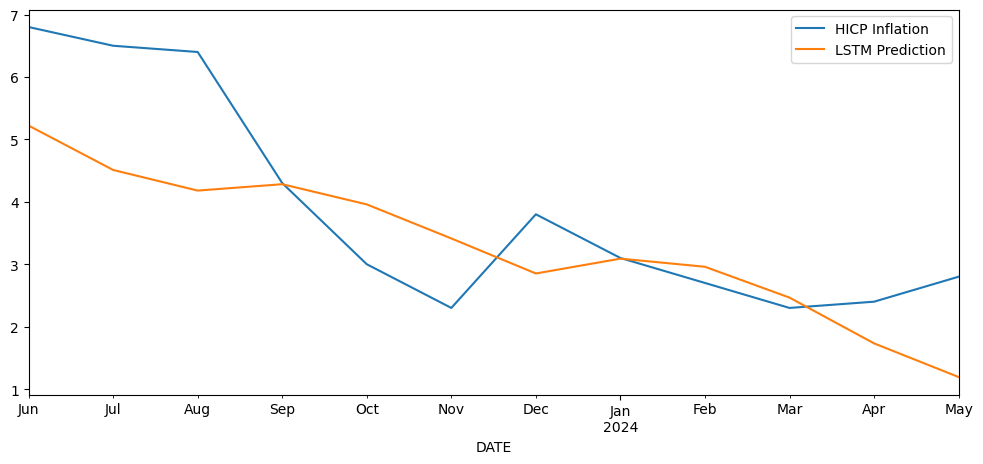

In [58]:
df_test["var1(t)"].plot(legend=True, figsize=(12,5), label="HICP Inflation")
df_test["Y_Pred"].plot(legend=True, label="LSTM Prediction");

### Forecasting into the future
*To forecast into the future, we retrain the model on the full dataset after which prediction is done 12 months into the future. Note that we do not have any test dataset to evaluate the model since we are predicting into the unknown future.*

In [59]:
data_t = scaler.fit_transform(data)

F_X_train, F_y_train = data_t[:, :-1],data_t[:, :-1]

F_X_train = torch.from_numpy(F_X_train).type(torch.Tensor)
F_y_train = torch.from_numpy(F_y_train).type(torch.Tensor)

F_X_train = F_X_train.view([F_X_train.shape[0], F_X_train.shape[1],1])
F_y_train = F_y_train.view([F_y_train.shape[0], F_y_train.shape[1],1])

In [60]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out


model_f = LSTM(input_dim=1,
             hidden_dim=500,
             output_dim=1,
             num_layers=1)

In [65]:

optimizer = torch.optim.Adam(model_f.parameters(), lr=0.001)

epochs = 400

for epoch in range(epochs):
    model_f.train()
    optimizer.zero_grad()

    out = model_f(F_X_train).reshape(-1, )
    loss = loss_fn(out,F_y_train)
    loss.backward()
    optimizer.step()



In [66]:
# Function to predict the next value
def predict_next(model_f, input_seq):
    model_f.eval()
    with torch.no_grad():
        input_seq = input_seq.unsqueeze(0)  # Add batch dimension
        pred = model_f(input_seq)
    return pred.squeeze(0).item()  # Remove batch dimension and convert to scalar

# Predicting 12 months into the future
current_seq = F_X_train[-1].clone()  # Start with the last sequence in the test set

future_predictions = []
n_future_steps = 12

for _ in range(n_future_steps):
    next_pred = predict_next(model_f, current_seq)
    future_predictions.append(next_pred)
    
    # Update the current sequence by appending the predicted value and removing the oldest value
    current_seq = torch.cat((current_seq[1:], torch.tensor([[next_pred]])), dim=0)

# Converting predicted values to original values    
dummies = np.zeros((X_test.shape[0], forward+1))
dummies[:, 0] = future_predictions
dummies = scaler.inverse_transform(dummies)

Future_predictions_12 = dc(dummies[:, 0])

##### 12 months predicted values (into the future)

In [67]:
start_date = pd.to_datetime('2024-06-30')
end_date = start_date + pd.DateOffset(months=12)  
date_index = pd.date_range(start=start_date, end=end_date, freq='MS') - pd.offsets.MonthEnd(1)

Data_forecast = pd.DataFrame({'Future LSTM Prediction': Future_predictions_12})
Data_forecast.index = date_index
Data_forecast

,Future LSTM Prediction
2024-06-30,1.882408
2024-07-31,1.881315
2024-08-31,1.880934
2024-09-30,1.880978
2024-10-31,1.880833
2024-11-30,1.880625
2024-12-31,1.880366
2025-01-31,1.880102
2025-02-28,1.879712
2025-03-31,1.879464
